<h1 align="center"><font size="5">Machine Learning: Modeling Loan Classifiers</font></h1>

# Objectives

The goal is to build an accurate model that can immediatley classify whether loans will be paid off or sent to collections based on data and features from past loans.
  * Build several loan classifier models using machine learning on a dataset about past loans.
  * Evaluate the accuracy of each model and determine the best model.

## Table of contents

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ol>
    <li><a href="#ref1">About the Data</a></li>
    <li><a href="#ref2">Preprocessing & Data Exploration</a></li>
    <li><a href="#ref3">Classification Models</a><ul>
        <li><a href="#ref4">K Nearest Neighbor(KNN)</a></li>
        <li><a href="#ref5">Decision Tree</a></li>
        <li><a href="#ref6">Support Vector Machine</a></li>
        <li><a href="#ref7">Logistic Regression</a></li>
    </ul>
    </li>
    <li><a href="#ref8">Model Evaluation Using Test set</a><ul> 
        <li><a href="#ref9">Preprocessing Test Set for Evaluation</a></li>
        <li><a href="#ref10">Testing Each Model</a></li>
    </ul>
    </li>
    <li><a href="#ref11">Evaluation Report</a></li>        
</ol>
</div>

<a id="ref1"></a>
# About the Data

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

<a id="ref2"></a>
# Pre-processing & Data Exploration

### Importing Modules

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### Downloading Data

In [2]:
%%capture
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Converting date columns to date time objects

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


Viewing how many of each class is in the data set.

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Plotting columns to underestand the data better:

In [7]:
%%capture
!pip install seaborn

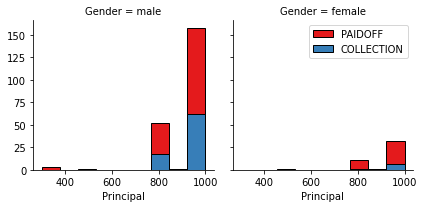

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

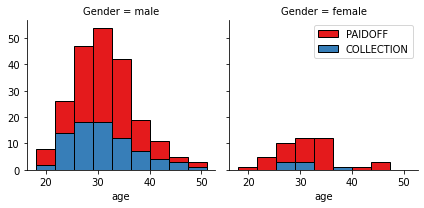

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

### Viewing the day of the week people get their loans

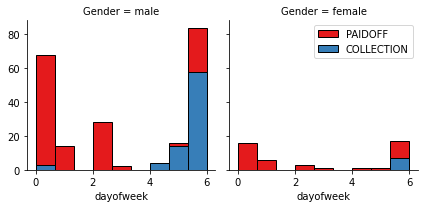

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

From the graphs above, it can be inferred that People who get the loan at the end of the week tend to not pay it off.
Feature binarization will be applied to set a threshold value less then day 4.

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


### Converting Categorical features to numerical values

Breaking down loan status by gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Converting male to 0 and female to 1 & converting 'Paidoff' to 0 and 'Collection' to 1. 

In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,0,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,0,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,0,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,0,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,0,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


### Breaking down loan status by education:

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              0              0.750000
                      1              0.250000
High School or Below  0              0.741722
                      1              0.258278
Master or Above       0              0.500000
                      1              0.500000
college               0              0.765101
                      1              0.234899
Name: loan_status, dtype: float64

Selecting Features before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


Using one hot encoding technique to convert 'Education' categorical varables to binary variables and appending them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Defining feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


Passing classification labels, Y:

In [18]:
y = df['loan_status'].values
y[0:5]

array([0, 0, 0, 0, 0])

### Normalize Data 

Applying Data Standardization to give the data zero mean and unit variance

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

<a id="ref3"></a>
# Classification Models

The training data set will be used to build several classification models with the following algorithms:

- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

Then the test set will be used to report the accuracy of each model using the following evaluation metrics when applicable:

- Jaccard Score
- F1-Score
- Logloss

<a id="ref4"></a>
## K Nearest Neighbor(KNN)

In [20]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

from sklearn.neighbors import KNeighborsClassifier

Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


array([0.67142857, 0.77142857, 0.71428571, 0.77142857, 0.75714286,
       0.78571429, 0.78571429, 0.77142857, 0.75714286, 0.75714286,
       0.7       , 0.68571429, 0.7       , 0.68571429])

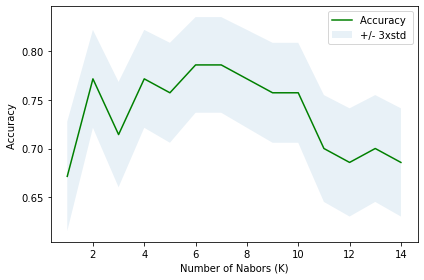

The best accuracy was with 0.7857142857142857 with k= 6


In [21]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [23]:
from sklearn.metrics import f1_score
print(f1_score(y_test, yhat, average='weighted')) 
from sklearn.metrics import jaccard_similarity_score
print(jaccard_similarity_score(y_test, yhat))

0.677295918367347
0.6857142857142857


<a id="ref5"></a>
## Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree.fit(X_train,y_train)
predTree = loanTree.predict(X_test)
print (predTree [0:5])
print (y_test [0:5])

[0 0 0 0 0]
[0 0 0 0 0]


In [25]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.7857142857142857


In [26]:
print(f1_score(y_test, predTree, average='weighted')) 
print(jaccard_similarity_score(y_test, predTree))

0.6914285714285714
0.7857142857142857


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<a id="ref6"></a>
## Support Vector Machine

In [27]:
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
yhat2 = clf.predict(X_test)
yhat2 [0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([1, 0, 0, 0, 0])

In [28]:
f1_score(y_test, yhat2, average='weighted') 

0.7275882012724117

In [29]:
jaccard_similarity_score(y_test, yhat2)

0.7428571428571429

<a id="ref7"></a>
## Logistic Regression

In [30]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [32]:
yhat3 = LR.predict(X_test)
yhat3_prob = LR.predict_proba(X_test)

print(f1_score(y_test, yhat3, average='weighted'))
print(jaccard_similarity_score(y_test, yhat3))

0.6670522459996144
0.6857142857142857


In [33]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat3_prob)

0.5772287609479654

<a id="ref8"></a>
# Model Evaluation Using Test set

Downloading the test set:

In [34]:
%%capture
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

<a id="ref9"></a>
## Preprocessing Test Set for Evaluation 

In [35]:
#passing csv file to a pandas dataframe
test_df = pd.read_csv('loan_test.csv')

#Converting date columns to datetime objects
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

#making 'dayof week' column
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

#making 'weekend' column
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

#grouping data by 'gender' and 'loan status'
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

#converting 'gender' and 'loan status' to binary variables
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)

#grouping by 'education' and 'loan status'
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

#selecting features for one hot encoding
Feature2 = test_df[['Principal','terms','age','Gender','weekend']]

#Using one hot encoding technique to convert 'Education' categorical varables to binary variables and appending them to the feature Data Frame 
Feature2 = pd.concat([Feature2,pd.get_dummies(test_df['education'])], axis=1)
Feature2.drop(['Master or Above'], axis = 1,inplace=True)
Feature2

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0
5,700,15,33,0,1,0,1,0
6,1000,15,24,0,1,0,0,1
7,1000,30,32,0,1,1,0,0
8,800,15,27,1,1,0,0,1
9,1000,15,37,0,1,0,0,1


In [36]:
# selecting x-features
X2 = Feature2
X2[0:5]

# passing classification labels for Y
y2 = test_df['loan_status'].values
y[0:5]

# Data standardizing
X2 = preprocessing.StandardScaler().fit(X2).transform(X2)
X2[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

<a id="ref10"></a>
## Testing Each Model 

In [37]:
#KNN Model tested with official test data
k = 6 
neigh2 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train) #model still uses initial training data
yhat_test = neigh2.predict(X2)


print(f1_score(y2, yhat_test, average='weighted'))
print(jaccard_similarity_score(y2, yhat_test))

0.626541384672668
0.6851851851851852


In [38]:
#Decision Tree tested with official test data
predTree_test = loanTree.predict(X2)

print(f1_score(y2, predTree_test, average='weighted'))
print(jaccard_similarity_score(y2, predTree_test))

0.6717642373556352
0.7592592592592593


In [39]:
#SVM tested with official test data
yhat2_test = clf.predict(X2)
print(f1_score(y2, yhat2_test, average='weighted'))
print(jaccard_similarity_score(y2, yhat2_test))

0.7583503077293734
0.7962962962962963


In [40]:
#Logistic Regression tested with official test data
yhat3_test = LR.predict(X2)
yhat3_prob_test = LR.predict_proba(X2)

print(f1_score(y2, yhat3_test, average='weighted'))
print(jaccard_similarity_score(y2, yhat3_test))
print(log_loss(y2, yhat3_prob_test))

0.6604267310789049
0.7407407407407407
0.5672153379912981


<a id="ref11"></a>
# Evaluation Report
Based on the evaluation metric scores for the testing data set of the loan data, the model that performed the most accurate classifcation was the support vector machine model.

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.68    | 0.63     | NA      |
| Decision Tree      | 0.76    | 0.67     | NA      |
| SVM                | 0.80    | 0.76     | NA      |
| LogisticRegression | 0.74    | 0.66     |  0.57   |